<h2>Supervised Regression</h2>

In this notebook we will use decision tree and random forests algorihtms to learn a mapping between galaxy magnitudes and colors and the spectroscopic redshift.

We will construct some learning curves to determine the best choices of the algorihtms.

We will then use feature importance to understand which of the features give us the most predictive power, and then train a very simiple algorithm with reduced feature list.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split

# download data from here: 
# http://alien.usm.uni-muenchen.de/SDSS/specPhotoDR12v3_hoyleb_extcorr_clean1e5.fit
d = Table.read('specPhotoDR12v3_hoyleb_extcorr_clean1e5.fit')

# will perform a bit of data cleaning.
d = d[d['SPECZ'] < 1.0]
d = d[d['SPECZ'] > 1e-3]


     SPECOBJID      SPEC_CLASS ... SPEC_CLASS_ID SPEC_SUBCLASS_ID
------------------- ---------- ... ------------- ----------------
 876000744266819584     GALAXY ...             0                0
1937785129938216960     GALAXY ...             0              157
4042054969858912256     GALAXY ...             0                0
1001077893977106432     GALAXY ...             0                0
6589924142006071296     GALAXY ...             0                0
8031301981161844736     GALAXY ...             0                0
 834465866618791936     GALAXY ...             0                0
4577944296930078720     GALAXY ...             0                0
 829812737721788416     QSO    ...             1              158
1145186210826708992     GALAXY ...             0                0
                ...        ... ...           ...              ...
1533635428354123776     GALAXY ...             0              159
5023923807959314432     GALAXY ...             0                0
 747731989

In [2]:
#you can look at the all the features available to you
# http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoObj+V
print (d.keys())


['SPECOBJID', 'SPEC_CLASS', 'SPEC_SUBCLASS', 'OBJID', 'RA', 'DEC', 'PHOTOZ', 'PHOTOZ_ERR', 'SPECZ', 'SPECZ_ERR', 'DERED_U', 'DERED_G', 'DERED_R', 'DERED_I', 'DERED_Z', 'MODELMAGERR_U', 'MODELMAGERR_G', 'MODELMAGERR_R', 'MODELMAGERR_I', 'MODELMAGERR_Z', 'SPECTYPE', 'PHOTPTYPE', 'PETRORAD_U', 'PETRORAD_G', 'PETRORAD_R', 'PETRORAD_I', 'PETRORAD_Z', 'PETRORADERR_U', 'PETRORADERR_G', 'PETRORADERR_R', 'PETRORADERR_I', 'PETRORADERR_Z', 'DEVRAD_U', 'DEVRADERR_U', 'DEVRAD_G', 'DEVRADERR_G', 'DEVRAD_R', 'DEVRADERR_R', 'DEVRAD_I', 'DEVRADERR_I', 'DEVRAD_Z', 'DEVRADERR_Z', 'DEVAB_U', 'DEVAB_G', 'DEVAB_R', 'DEVAB_I', 'DEVAB_Z', 'EXTINCTION_U', 'EXTINCTION_G', 'EXTINCTION_R', 'EXTINCTION_I', 'EXTINCTION_Z', 'CMODELMAG_U', 'CMODELMAGERR_U', 'CMODELMAG_G', 'CMODELMAGERR_G', 'CMODELMAG_R', 'CMODELMAGERR_R', 'CMODELMAG_I', 'CMODELMAGERR_I', 'CMODELMAG_Z', 'CMODELMAGERR_Z', 'PSFMAG_U', 'PSFMAGERR_U', 'PSFMAG_G', 'PSFMAGERR_G', 'PSFMAG_R', 'PSFMAGERR_R', 'PSFMAG_I', 'PSFMAGERR_I', 'PSFMAG_Z', 'PSFMAGERR_Z

In [3]:
# we will use just dereddend magnitudes 
mags = ['DERED_U', 'DERED_G', 'DERED_R','DERED_I','DERED_Z']

#and color combinations created from them.
cols= []
for i in range(len(mags)):
    for j in range(i, len(mags)):
        cols.append(mags[i]+'-' + mags[j])
# let's load these into an input array
inputs = np.zeros((len(d), len(mags+cols)), dtype=float)
for i, key in enumerate(mags):
    inputs[:, i] = np.array(d[key])

print(inputs.shape)

cnt = len(mags)
for i in range(len(mags)):
    for j in range(i, len(mags)):
        inputs[:, cnt] = np.array(d[mags[i]] - d[mags[j]])
        cnt += 1

# The target/label values are spectroscopic redshifts
targets = np.array(d['SPECZ'])
print(targets)

(49424, 20)
[0.09504566 0.03471565 0.25370368 ... 0.40679774 0.09768907 0.26298884]


In [4]:
# we will split the data into a trainind and testing sample.
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.4, random_state=42)

<h3>Learning curves</h3>

Recall the lecture notes.

We will increase the complexity of the base algorihtm, a decision tree and/ or a random forest.

We then measure the error in the predictions for the train and test data.

C:\Users\vip\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Text(0,0.5,'Mean Squ. Error')

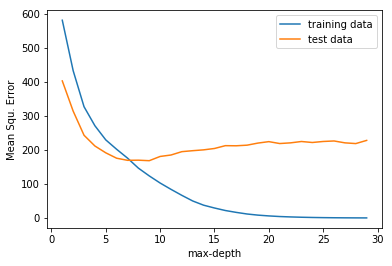

In [5]:
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as AB

#see https://scikit-learn.org/stable/modules/tree.html

#e.g. for max_depth
max_depths = range(1, 30)

MSE_test = []
MSE_train = [] 

for max_depth in max_depths:
    clf = DT(max_depth=max_depth)
    
    clf.fit(x_train, y_train)     
    MLz  = clf.predict(x_test)
 
    mse_test = np.mean(np.sum((MLz - y_test)**2))
    MSE_test.append(mse_test)

    MLz_train = clf.predict(x_train)
    mse_train = np.mean(np.sum((MLz_train - y_train)**2))
    MSE_train.append(mse_train)

plt.plot(max_depths, MSE_train, label='training data')
plt.plot(max_depths, MSE_test, label='test data')
plt.legend()
plt.xlabel('max-depth')
plt.ylabel('Mean Squ. Error')


Text(0,0.5,'Mean Squ. Error')

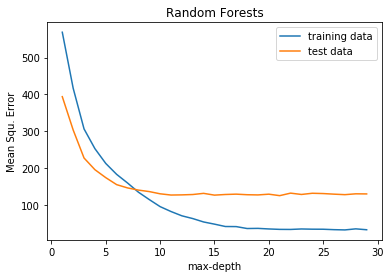

In [25]:
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as AB

#see https://scikit-learn.org/stable/modules/tree.html

#e.g. for max_depth
max_depths = range(1, 30)

MSE_test = []
MSE_train = [] 

for max_depth in max_depths:
    clfRF = RF(max_depth=max_depth)
    
    clfRF.fit(x_train, y_train)     
    MLz  = clfRF.predict(x_test)
 
    mse_test = np.mean(np.sum((MLz - y_test)**2))
    MSE_test.append(mse_test)

    MLz_train = clfRF.predict(x_train)
    mse_train = np.mean(np.sum((MLz_train - y_train)**2))
    MSE_train.append(mse_train)

plt.figure()
plt.plot(max_depths, MSE_train, label='training data')
plt.plot(max_depths, MSE_test, label='test data')
plt.legend()
plt.title('Random Forests')
plt.xlabel('max-depth')
plt.ylabel('Mean Squ. Error')

Text(0,0.5,'Mean Squ. Error')

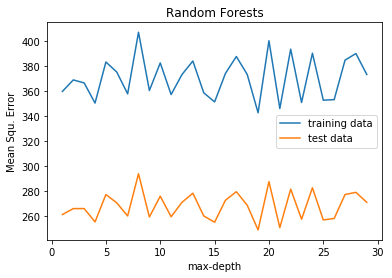

In [28]:
from sklearn.ensemble import AdaBoostRegressor as AB

#see https://scikit-learn.org/stable/modules/tree.html

#e.g. for max_depth
max_depths = range(1, 30)

MSE_test = []
MSE_train = [] 

for max_depth in max_depths:
    clfAB = AB()
    
    clfAB.fit(x_train, y_train)     
    MLz  = clfAB.predict(x_test)
 
    mse_test = np.mean(np.sum((MLz - y_test)**2))
    MSE_test.append(mse_test)

    MLz_train = clfAB.predict(x_train)
    mse_train = np.mean(np.sum((MLz_train - y_train)**2))
    MSE_train.append(mse_train)

plt.figure()
plt.plot(max_depths, MSE_train, label='training data')
plt.plot(max_depths, MSE_test, label='test data')
plt.legend()
plt.title('Random Forests')
plt.xlabel('max-depth')
plt.ylabel('Mean Squ. Error')

<h4>Label the above plot and think about the meaning of being in the high bias, and then high variance regime</h4>

<h3>Feature importance</h3>

Let's use one of the above systems, and obtain the feature importance scores.

Then let's feed that into a different algorithm, and explore predictive power.

In [6]:
clf = DT(max_depth=6)
clf.fit(x_train, y_train) 

for FI, column in zip(clf.feature_importances_, mags + cols):
    print (column, FI) 

DERED_U 0.0029195501366341497
DERED_G 0.01046327809452048
DERED_R 0.04731925721836492
DERED_I 0.6751595262371414
DERED_Z 0.011164232972345027
DERED_U-DERED_U 0.0
DERED_U-DERED_G 0.01143252302398039
DERED_U-DERED_R 0.0003609678223495337
DERED_U-DERED_I 0.10516732089921504
DERED_U-DERED_Z 0.0
DERED_G-DERED_G 0.0
DERED_G-DERED_R 0.060485206144585656
DERED_G-DERED_I 0.006737139828531772
DERED_G-DERED_Z 0.014516083594040883
DERED_R-DERED_R 0.0
DERED_R-DERED_I 0.02650546233322952
DERED_R-DERED_Z 0.012546424126448099
DERED_I-DERED_I 0.0
DERED_I-DERED_Z 0.015223027568613226
DERED_Z-DERED_Z 0.0


In [14]:
#ind_sort should contain the an array of  columns numbers which correspond to the most important features
ind_sort = np.array([None, None, None, None])

ind_sort = np.flip(np.argsort(clf.feature_importances_))
print(ind_sort)

#print(np.array(['DERED_I']))

[ 3  8 11  2 15 18 13 16  6  4  1 12  0  7 19  5 10 14 17  9]


In [17]:
#and select the top 4 and feed them into another algorithm
#ind_sort = inputs
top4 = ind_sort[0:4]
print (top4)
# we will split the data into a trainind and testing sample.
x4_train, x4_test, y4_train, y4_test = train_test_split(inputs[:, top4], targets, test_size=0.4, random_state=42)


[ 3  8 11  2]


train data (29654, 4) (29654,)
test data (19770, 4) (19770,)


Text(0,0.5,'target value')

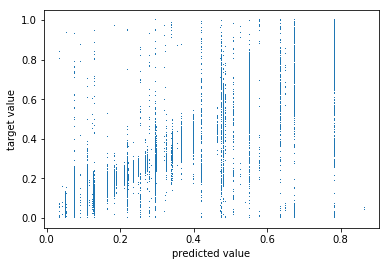

In [18]:
# choose your own algorithm from sklean regression
# https://scikit-learn.org/stable/supervised_learning.html
# they all have the same interface as the below

from sklearn.tree import DecisionTreeRegressor as DT
clf = DT(max_depth=6)
print ('train data', np.shape(x4_train), np.shape(y4_train))
print ('test data', np.shape(x4_test), np.shape(y4_test))
clf.fit(x4_train, y4_train) 
pred = clf.predict(x4_test)
plt.plot(pred, y4_test, ',')
plt.xlabel('predicted value')
plt.ylabel('target value')

train data (29654, 4) (29654,)
test data (19770, 4) (19770,)


Text(0,0.5,'target value')

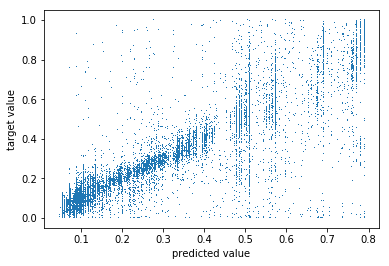

In [23]:
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as AB
clf = RF(max_depth=6)
print ('train data', np.shape(x4_train), np.shape(y4_train))
print ('test data', np.shape(x4_test), np.shape(y4_test))
clf.fit(x4_train, y4_train) 
pred = clf.predict(x4_test)
plt.plot(pred, y4_test, ',')
plt.xlabel('predicted value')
plt.ylabel('target value')

train data (29654, 4) (29654,)
test data (19770, 4) (19770,)


Text(0,0.5,'target value')

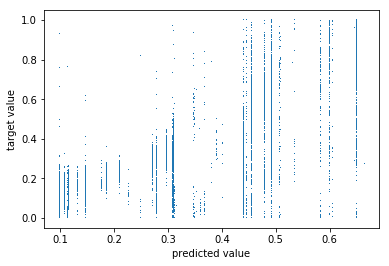

In [30]:
#from sklearn.isotonic import IsotonicRegression as IR
clf = AB()
print ('train data', np.shape(x4_train), np.shape(y4_train))
print ('test data', np.shape(x4_test), np.shape(y4_test))
clf.fit(x4_train, y4_train) 
pred = clf.predict(x4_test)
plt.plot(pred, y4_test, ',')
plt.xlabel('predicted value')
plt.ylabel('target value')